# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau

  - Exemples de référence

  - Analyse des ensembles de niveau (Q1, Q2, Q3, Q4)

- Construction des courbes de niveau

  - Méthode de Newton (Q5, T1, T2)

  - Génération des points (Q6, T3)

  - Bouclage et auto-intersection (Q7, T4, T5)

- Post-traitement

  - Interpolation (Q8, T6)

  - Intégration (T7, T8)

## Préambule

### Dépendances logicielles 

In [1]:
# Python Standard Library
# -----------------------
pass

In [2]:
# Third-Party Libraries
# ---------------------

# Autograd & Numpy
import autograd
import autograd.numpy as np
import math

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [3]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [4]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

#### Exemples d'usage

In [5]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(0.0, 0.0) # array([1., 2.])

array([1., 2.])

In [6]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

#### Précautions

Les deux sources d'erreurs (avec messages cryptiques) les plus communes avec autograd :

**Selection de NumPy**

N'importez pas NumPy directement, par exemple avec

    >>> import numpy as np # Wrong !

mais importez le module `numpy` qui a été modifié par `autograd` (pour que les fonctions du module "coopérent" avec les algorithmes de différentiation automatique). 

    >>> import autograd.numpy as np # Right !
    
Utilisez-le ensuite comme vous le feriez avec NumPy classique.

**Utilisez des doubles**

Les fonctions générées par autograd sont strictes quand au type des nombres utilisés (plus strictes que les fonctions NumPy) : il doit s'agir de doubles. Par exemple, si l'on définit

    >>> def add(x, y):
    ...    return x + y
    >>> grad_add = grad(add)

Alors `grad_add(0.0, 0.0)` renvoie `array([1.0, 1.0])`, mais `grad_add(0, 0)` génère une erreur, car ses arguments sont des entiers et non des doubles.


## Ensembles de niveau

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x_1,x_2) \in \mathbb{R}^2 \; | \; f(x_1, x_2) = c\}.
$$


### Exemples de référence

On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [7]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [8]:
def f1(x1, x2):
    x1 = np.array(x1)
    x2 = np.array(x2)
    return 3.0 * x1 * x1 - 2.0 * x1 * x2 + 3.0 * x2 * x2 

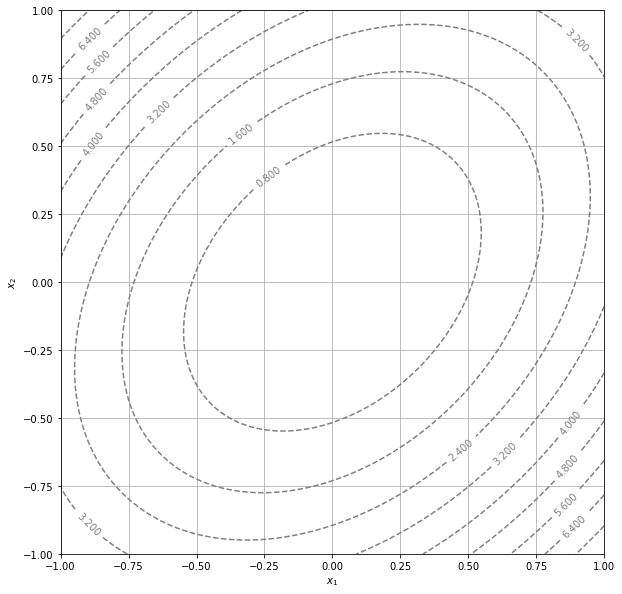

In [9]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x_1,x_2) \in \mathbb{R}^2 \mapsto (x_1 - 1)^2 + (x_1 - x_2^2)^2
$$

In [10]:
def f2(x1, x2):
    return (x1 - 1)**2 + (x1 - x2**2)**2

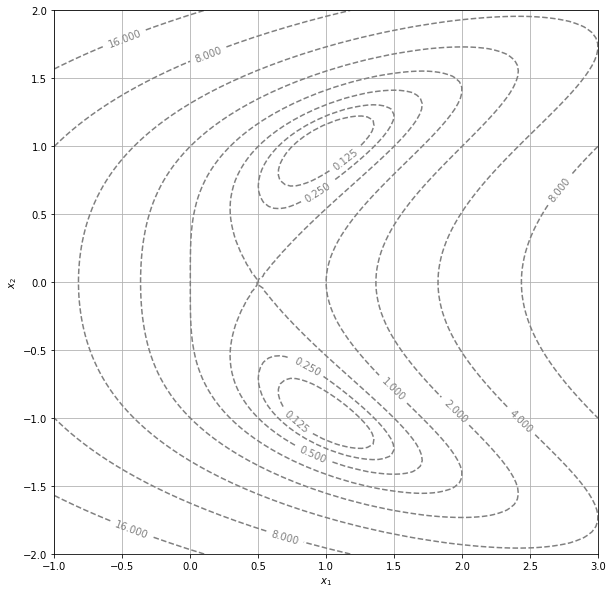

In [11]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [12]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

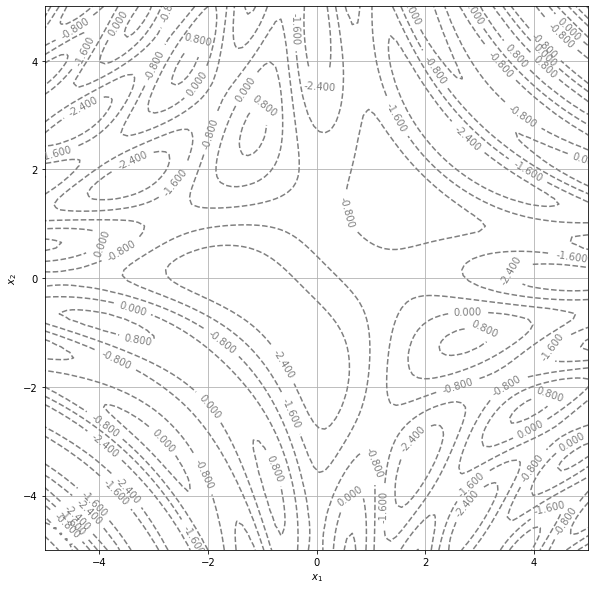

In [13]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

### Analyse des ensembles de niveau

#### Question 1

Soit $c \in \mathbb{R}$.
On suppose que la fonction $f:\mathbb{R}^2 \to \mathbb{R}$ est continue et vérifie
$f(x_1, x_2) \to +\infty$ quand $\|(x_1,x_2)\| \to +\infty$.
Que peut-on dire de l'ensemble de niveau $c$ de $f$ ?

#### Réponse 1

Notons C l'ensemble de niveau c de $f$.
Nous allons montrer que C est un compact.
Il suffit de montrer que C est un fermé borné car nous sommes en dimension finie.

- C est fermé :
    En effet, $f$ est continue $C = f^{-1}(\left\{c\right\})$

- C est borné :
    Soit $x \in$ C.
    On a $f(x) = c$.
    Or, $f(x) \to +\infty$ quand $\|(x_1,x_2)\| \to +\infty$, donc il exite A $\in \mathbb{R}$ tel que :
    $\forall x \in \mathbb{R^2}, \|x\| > A \implies \|f(x)\| > c$
    Ainsi, $\forall x\in$ C, $\|x\|\leq \ A$.

C est donc un fermé et borné de $\mathbb{R^2}$ qui est de dimension finie , c'est un compacte de $\mathbb{R^2}$

Dans la suite la fonction $f$ est supposée continûment différentiable. On suppose également que le gradient $\nabla f$ ne s'annule pas dans un voisinage du point $x_0 = (x_{10}, x_{20}) \in \mathbb{R}^2$. On pose alors
$$
p(x_1, x_2) := \frac{\partial_2 f(x_0)}{\|\nabla f(x_0)\|} (x_1 - x_{10}) -
\frac{\partial_1 f(x_0)}{\|\nabla f(x_0)\|} (x_2 - x_{20}).
$$




#### Question 2
Comment interpréter géométriquement le terme $p(x_1,x_2)$ ?

#### Réponse 2

On remarque que $p(x_1, x_2)$ est le déterminent d'une matrice, ou encore de 2 vecteurs :

$p(x_1, x_2) = det(x, \frac{\nabla f(x_0)}{\|\nabla f(x_0)\|})$
ou $x = \begin{pmatrix} x_1 \\ x_2 \end{pmatrix}$
et $\frac{\nabla f(x_0)}{\|\nabla f(x_0)\|} = \frac{1}{\|\nabla f(x_0)\|} \begin{pmatrix} \partial_1 f(x_0) \\ \partial_2 f(x_0) \end{pmatrix}$

Ainsi, $p(x_1, x_2)$ est l'aire du parallélogramme engendré par les vecteurs 
$\begin{pmatrix} x_1 \\ x_2 \end{pmatrix}$ et $\frac{\nabla f(x_0)}{\|\nabla f(x_0)\|}$.

#### Question 3

Montrer que dans un voisinage ouvert de $x_0$, on peut paramétriser l'ensemble de niveau $c:=f(x_0)$ au moyen de $p(x_1,x_2),$ c'est-à-dire qu'il existe un $\varepsilon > 0$ et une fonction (continûment différentiable) $\gamma :\left]-\varepsilon,\varepsilon \right[ \to \mathbb{R}^2$ tels que dans un voisinage ouvert de $x_0,$ $f(x_1,x_2) = c$ si et seulement si $(x_1, x_2) = \gamma(t)$ où $t = p(x_1, x_2)$.

#### Réponse 3

Construisons une fonction $F:\mathbb{R}^3 \to \mathbb{R}^2$ pour appliquer le théorème des fonctions implicites :

Posons donc $F(x_1, x_2, t) = \begin{pmatrix} f(x_1, x_2) - c \\ p(x_1, x_2) - t \end{pmatrix}$

$f$ est continûment différentiable, $p$ est dérivable (par rapport à t) et continûment différentiable par rapport à $\begin{pmatrix} x_1 \\ x_2 \end{pmatrix}$. $F$ est donc continûment différentiable et

$$
d_{(x_1, x_2)} F(x_{1}, x_{2}, t) = J_{(x_1, x_2)} F(x_{1}, x_{2}, t) = \begin{pmatrix} \partial_1 f(x_{1}, x_{2}) & \partial_2 f(x_{1}, x_{2}) \\ \partial_1 p(x_{1}, x_{2}) & \partial_2 p(x_{1}, x_{2}) \end{pmatrix} = \begin{pmatrix} \partial_1 f(x_{1}, x_{2}) & \partial_2 f(x_{1}, x_{2}) \\ \frac{\partial_2 f(x_{10}, x_{20})}{\|\nabla f(x_0)\|} & \frac{- \partial_1 f(x_{10}, x_{20})}{\|\nabla f(x_0)\|} \end{pmatrix}
$$

Ainsi, $det(J_{(x_1, x_2)} F(x_{10}, x_{20}, t)) = - \frac{\partial_1 f^2(x_{10}, x_{20}) + \partial_2 f^2(x_{10}, x_{20})}{\|\nabla f(x_0)\|} = -{\|\nabla f(x_0)\|}$

Or, $\nabla f$ ne s'annule pas en $x_0$ (et sur tout un voisinage de $x_0$).
De plus, $F(x_0, 0) = 0$

On peut donc appliquer le théorème des fonctions implicites à $F$ :

Il existe un voisinage ouvert U de $x_0$ et V de 0 (que l'on peut prendre de la forme $\left] - \varepsilon, \varepsilon \right[$ et une fonction $\gamma :\left]-\varepsilon,\varepsilon \right[ \to \mathbb{R}^2$ telle que sur U, $F(x_1,x_2, t) = 0$ si et seulement si $(x_1, x_2) = \gamma(t)$, c'est à dire $f(x_1,x_2) = c$ si et seulement si $(x_1, x_2) = \gamma(t)$ où $t = p(x_1, x_2)$.

#### Question 4

Montrer que pour tout $t \in \left]-\varepsilon, \varepsilon \right[$ :

  - le vecteur $\gamma'(t)$ est non nul (il fournit donc une tangente au chemin $\gamma$),

  - est orthogonal à $\nabla f(\gamma(t))$.

#### Réponse 4

D'après le théorème des fonctions implicites, 

$\gamma'(t) = -d_{(x_1, x_2)} F(x_{1}, x_{2}, t)^{-1} d_tF(x_{1}, x_{2}, t) = \frac{1}{\|\nabla f(x_0)\|} \begin{pmatrix} - \frac{\partial_1 f(x_{10}, x_{20})}{\|\nabla f(x_0)\|} & - \partial_2 f(x_{1}, x_{2}) \\ - \frac{\partial_2 f(x_{10}, x_{20})}{\|\nabla f(x_0)\|} & \partial_1 f(x_{1}, x_{2}) \end{pmatrix} \begin{pmatrix} 0 \\ -1 \end{pmatrix} = \begin{pmatrix} \frac{\partial_2 f(x_{1}, x_{2})}{\|\nabla f(x_0)\|} \\ -\frac{\partial_1 f(x_{1}, x_{2})}{\|\nabla f(x_0)\|} \end{pmatrix}$

Ce vecteur est non nul car il a à l'ordre et au signe près les mêmes compostantes que $\nabla f$ qui ne s'annule pas sur $\left] - \varepsilon, \varepsilon \right[$

$ \langle \gamma'(t),\nabla f(\gamma(t))\rangle = \frac{1}{\|\nabla f(x_0)\|} \begin{pmatrix} \partial_1 f(\gamma (t)) & \partial_2 f(\gamma (t)) \end{pmatrix} \begin{pmatrix} \frac{\partial_2 f(x_{1}, x_{2})}{\|\nabla f(x_0)\|} \\ -\frac{\partial_1 f(x_{1}, x_{2})}{\|\nabla f(x_0)\|} \end{pmatrix} = \frac{\partial_1 f(x_{1}, x_{2}) \partial_2 f(x_{1}, x_{2}) - \partial_2 f(x_{1}, x_{2}) \partial_1 f(x_{1}, x_{2})}{\|\nabla f(x_0)\|} = 0$

Ainsi, le vecteur $\gamma'(t)$ est orthogonal à $\nabla f(\gamma(t))$.

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $x_0 \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

#### Question 5

L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

In [14]:
N = 100
eps = 10**(-4)

#### Tâche 1

Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [15]:
def Newton(F, x0, y0, eps=eps, N=N):
    J_F = J(F)
    for i in range(N):
        inv_J = np.linalg.inv(J_F(x0,y0))
        A = - inv_J.dot(F(x0,y0))
        x, y = x0 + A[0], y0 +A[1]
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps:
            return x, y
        x0, y0 = x, y
    else:
        raise ValueError(f"no convergence in {N} steps.")

#### Tâche 2

Testez votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x_1, x_2)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x_1 = x_2$ en utilisant le point initial $(0.8, 0.8)$. Puis de faire varier le point initial, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

In [16]:
def ftest(x, y):
    return np.array([f1(x, y) - 0.8, x - y])

In [17]:
u, v = 0.8, 0.8
uu, vv = Newton(ftest, u, v)

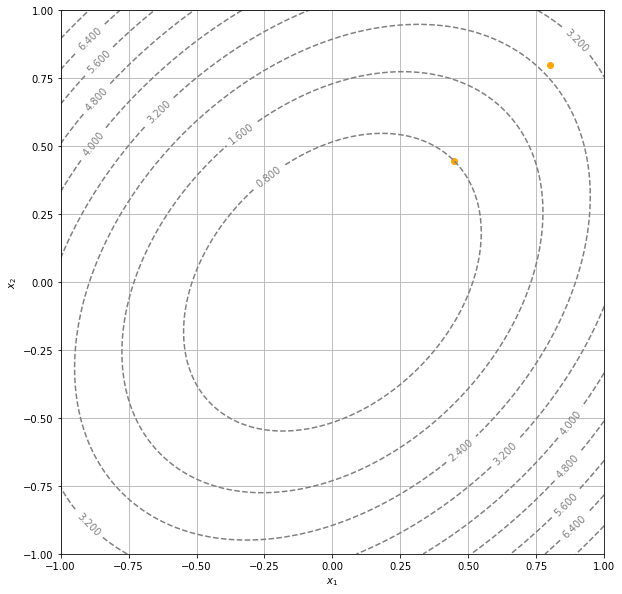

In [18]:
# affichage d'un point et du résultat de la méthode de newton
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

plt.scatter(u, v,color = 'orange')
plt.scatter(uu, vv, color = 'orange');

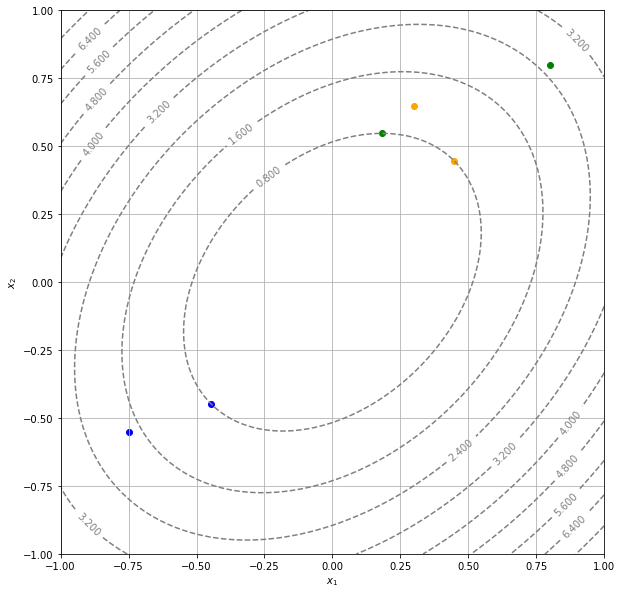

In [19]:
def ftest(x, y):
    return np.array([f1(x, y) - 0.8, x - y])
u, v = 0.3, 0.65#on a changé le point initial
uu, vv = Newton(ftest, u, v)

a, b = -0.75, -0.55
aa, bb = Newton(ftest, a, b)

def ftest2(x, y):
    return np.array([f1(x, y) - 0.8, 3 * x - y])#on a changé la condition

x, y = 0.8, 0.8
xx, yy = Newton(ftest2, x, y)

display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

plt.scatter(u, v,color = 'orange')
plt.scatter(uu, vv, color = 'orange')

plt.scatter(a, b,color = 'blue')
plt.scatter(aa, bb, color = 'blue')

plt.scatter(x, y,color = 'green')
plt.scatter(xx, yy, color = 'green');

### Génération des points

#### Question 6 + Tâche 3
Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille `(2, N)` contenant les coordonnées des points correspondants, puis valider graphiquement le résultat au moyen des exemples de référence.

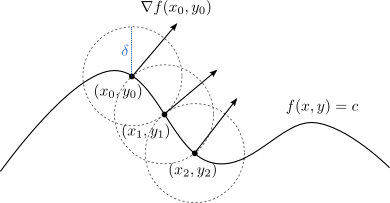

### Réponse 6
On se place en (x0,y0).Pour pouvoir aller "a droite" du gradient il suffit de faire une rotation du gradient d'angle -$\frac{\pi}{2}$ et pour être proche de $\delta$ on donne a ce vecteur u (issue de la rotation) comme norme $\delta$ on applique ensuite la methode de Newton  au point(x1,y1) obtenue par la translation de (x0,y0) par le vecteur u et à la fonction $F:\mathbb{R}^2 \to \mathbb{R}^2$ tel que $F(x, y)=(f(x, y) - c, (x - x0)^2 + (y - y0)^2 - \delta^2)$

In [20]:
def next(f,x0, y0, delta=0.1):
    grad_f = grad(f)
    n = np.sqrt(grad_f(x0,y0)[0]**2+grad_f(x0,y0)[1]**2)
    a,b=grad_f(x0,y0) * delta / n 
    x1, y1 = x0 + b, y0 - a #c'est les coordonnes pt a distance delta a droite perpendiculairement au gradient
    return x1, y1      
        

In [21]:
def level_curve(f, x0, y0, delta=0.1, N=200, eps=eps):
    c = f(x0,y0)
    tableau = np.zeros([2,N])
    def F(x, y):
            return np.array([f(x, y) - c, (x - x0)**2 + (y - y0)**2 - delta**2])
    for i in range(N):
        tableau[0][i], tableau[1][i] = x0, y0
        x1, y1 = next(f, x0, y0, delta = 0.1)
        x0, y0 = Newton(F, x1, y1, eps, N = 100)
    return tableau 

In [22]:
a, b = level_curve(f1, 0.45, 0.45)

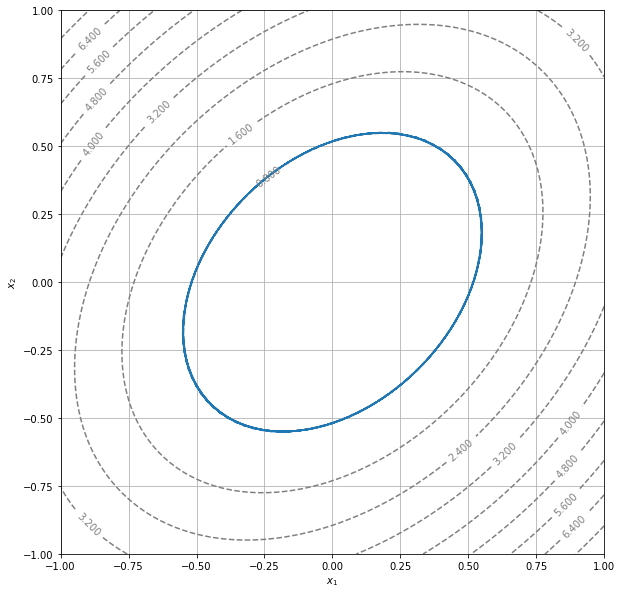

In [23]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)
plt.plot(a, b);


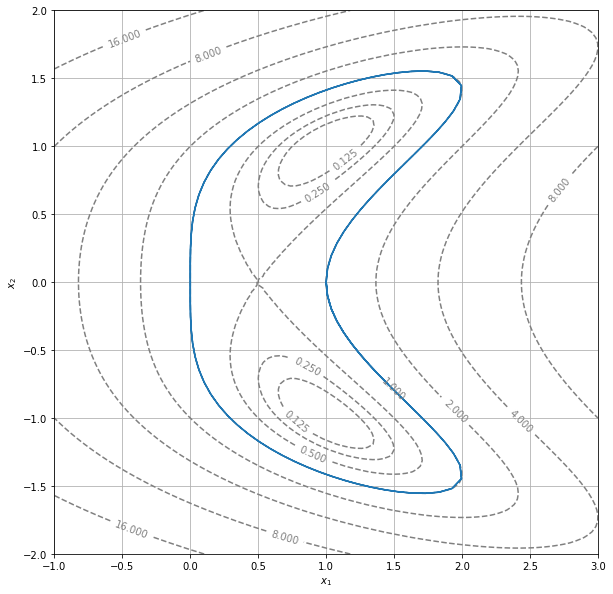

In [24]:
a, b = level_curve(f2, 1., 0.)

display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)
plt.plot(a, b);

### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

#### Question 7 + Tâche 4

Proposer une nouvelle implémentation de `level_curve` qui arrête l'algorithme et renvoie les points connus quand le segment formé par les deux derniers points produits intersecte l'un des segments produits auparavant. En étant (raisonnablement) optimiste, doit-t'on prendre la peine de tester l'intersection du dernier segment avec tous les segments déjà produits (ce qui prend du temps ...) ou juste avec le premier ? Pour répondre à cette question, on pourra se demander si les courbes de niveau similaires à celle de la fonction de Rosenbrock passant par le point $(0.5, 0)$ (cf. Exemples de référence) -- c'est-à-dire "auto-intersectantes" -- sont fréquentes ou rares et pourquoi.

#### Réponse 7
On peut considérer que les fonctions "auto-intersectantes" sont rares car au point d'intersection le gradient doit être nul.Or nous appliquons en general la methode de Newton à des fonctions dont le gradient est non nul donc on ne risque pas de les rencontrer très souvent.

In [25]:
def isin(x0, y0, x1, y1, x2, y2, x3, y3):
    if (x0 == x1 and x2 == x3) or (y0 == y1 and y2 == y3):
        return False
    if x2 == x3 :
        x0, y0, x2, y2, x1, y1, x3, y3 = x2, y2, x0, y0, x3, y3, x1, y1     
    if x0 == x1 :
        a = (y3 - y2) / (x3 - x2)
        b = (y2 * x3 - y3 * x2) / (x3 - x2)
        x, y = x0, a * x0 + b
        c, d, e, f, g, h = min(x2, x3), max(x2, x3), min(y0, y1), max(y0, y1), min(y2, y3), max(y2, y3)
        return ((x >= c) and (x <= d) and (y >= e) and (y <= f) and (y >= g) and (y <= h))
    else :
        a1 = (y1 - y0) / (x1 - x0)
        a2 = (y3 - y2) / (x3 - x2)
        b1 = (y0 * x1 - y1 * x0) / (x1 - x0)
        b2 = (y2 * x3 - y3 * x2) / (x3 - x2)
        if math.isclose(a1, a2):
            return False
        else :
            x = (b2 - b1) / (a1 - a2)
            y = a1 * x + b1
            c, d, e, f = min(x1, x0), max(x1, x0), min(x2, x3), max(x2, x3)
            g, h, i, j = min(y0, y1), max(y0, y1), min(y2, y3), max(y2, y3)
            bool1 = ((x >= c) and (x <= d) and (x >= e) and (x <= f))
            bool2 = ((y >= g) and (y <= h) and (y >= i) and (y <= j))
            return (bool1 and bool2)

In [26]:
def level_curve2(f, x0, y0, delta=0.1, N=100, eps=eps):
    c=f(x0,y0)
    def F(x,y):
        return np.array([f(x,y)-c,(0.999*x - x0)**2 + (0.99*y - y0)**2-delta**2])
    tableau=[[x0,y0]]
    a,b=next(f,x0,y0,delta=0.1)#pour nous permettre de fixer deja les 2 points de depart ici 
    x1,y1=Newton(F,a,b,eps,N=100)#a et b sont justes intermediaires pour trouver x1 et y1
    tableau.append([x1,y1])
    x0,y0=x1,y1
    b=0
  #pour bien conserver nos x1,y1 pour appliquer la fct intersect
    for i in range(N-1):#on est deja 'rentre' dans la boucle une fois pour trouver x1,y1
        d,e=next(f,x0,y0,delta=0.1)
        x0,y0=Newton(F,d,e,eps,N=100)
        tableau.append([x0,y0])
        b+=1#j'implemente un compteur pour bien verfier que l'on peut tracer avec moins de Npts
        if isin(tableau[0][0],tableau[0][1],tableau[1][0],tableau[1][1],tableau[i+1][0],tableau[i+1][1],x0,y0):
            print(f"l'algorithme s'arrête après {b} points")
            break
    return np.transpose(tableau)

In [27]:
def level_curve_2bis(f, x0, y0, delta=0.1, N=200, eps=eps):
    c = f(x0,y0)
    tableau = np.zeros([2,N])
    def F(x, y):
            return np.array([f(x, y) - c, (x - x0)**2 + (y - y0)**2 - delta**2])
    xa, ya = x0, y0
    x1, y1 = next(f, x0, y0, delta = 0.1)#pour nous permettre de fixer deja les 2 points de depart ici 
    xb, yb = Newton(F, x1, y1, eps, N = 100)#x1 et y1 sont justes intermediaires pour trouver xb et yb
    i = 0
    while i <= 1 or (not isin(xa, ya, xb, yb, tableau[0][i - 2], tableau[1][i - 2], tableau[0][i - 1], tableau[1][i - 1])):
        tableau[0][i], tableau[1][i] = x0, y0
        x1, y1 = next(f, x0, y0, delta = 0.1)
        x0, y0 = Newton(F, x1, y1, eps, N = 100)
        i += 1
    tableau[0][i], tableau[1][i] = x0, y0
    print(f"l'algorithme s'arrête apres {len(tableau[::, 0 : i + 1])} points")
    return tableau[::, 0 : i + 1]

#### Tâche 5

Valider graphiquement le résultat au moyen des exemples de référence.

l'algorithme s'arrête après 34 points


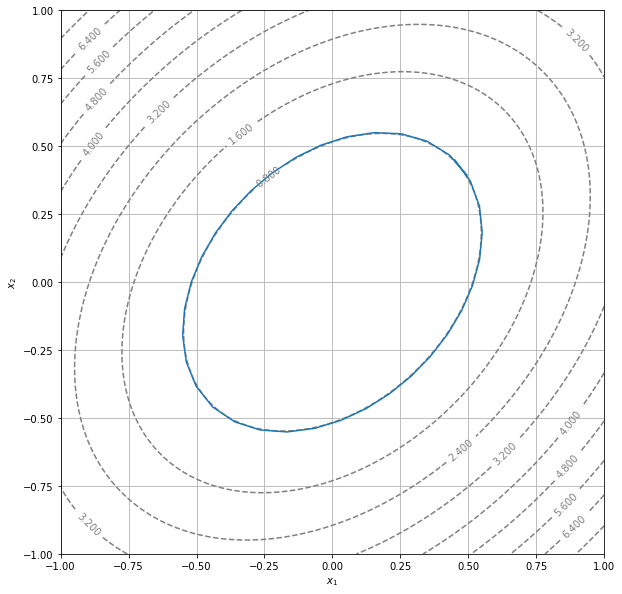

In [28]:
u, v = 0.45, 0.45
a, b = level_curve2(f1, u, v, delta = 0.1)
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)
plt.plot(a,b);

l'algorithme s'arrête après 30 points


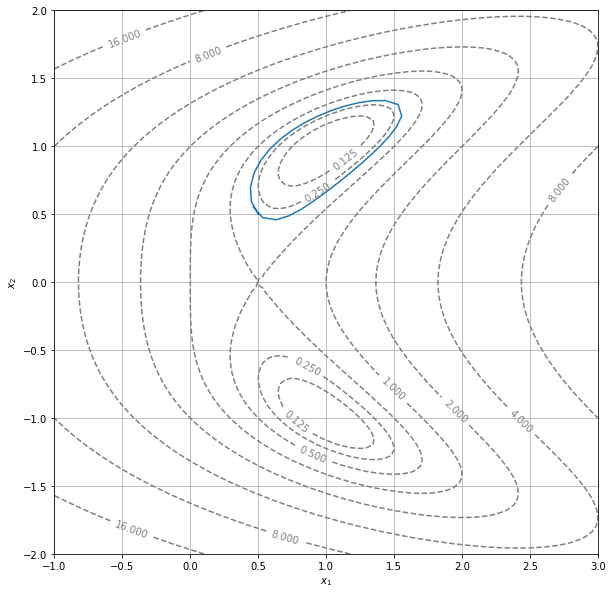

In [29]:
a,b=level_curve2(f2,0.5,0.5)
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)
plt.plot(a,b);

l'algorithme s'arrête après 55 points


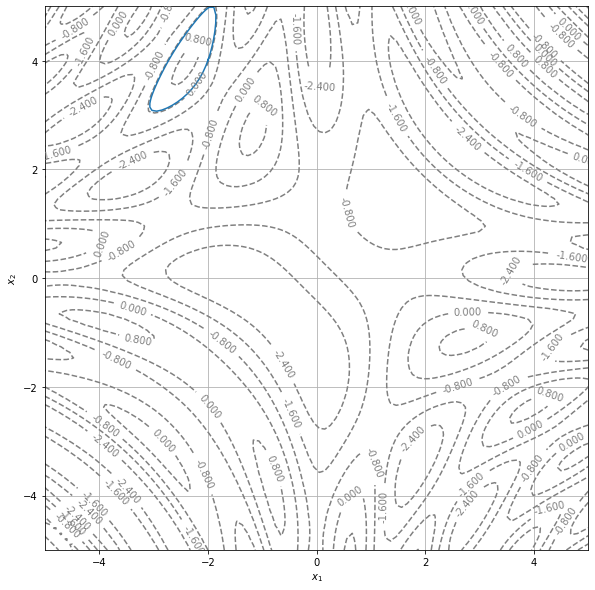

In [30]:
a,b=level_curve2(f3,-2.0,4.0 )

display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)
plt.plot(a,b);

## Post-traitement

Pour améliorer le rendu des courbes de niveau, il est tentant de diminuer la distance $\delta$ entre deux points consécutifs. Malheureusement, dans des cas d'usage réalistes, il est fréquent que la fonction $f$ soit beaucoup plus complexe que les exemples qui nous avons considérés. Le nombre de fois où cette fonction est appelée est alors le principal facteur qui détermine le temps de calcul des lignes de niveau. On cherche donc dans cette section à améliorer la qualité visuelle des résultats sans faire exploser le nombre d'évaluation de la fonction $f$. On va chercher à résoudre ce problème en reliant les points successifs par des chemins plus "flexibles" que des segments de droites, ayant le potentiel de mieux coller aux lignes de niveau.

### Interpolation 

#### Question 8

Soit $P_1$ et $P_2$ deux points du plan et $u_1$ et $u_2$ deux vecteurs du plan non nuls.
On cherche à produire un chemin $\gamma: [0,1] \to \mathbb{R}^2$ continûment différentiable, joignant $P_1$ et $P_2$ ($\gamma(0) = P_1$ et $\gamma(1) = P_2$), tel que $\gamma'(0)$ soit dans la même direction et le même sens que $u_1$ et $\gamma'(1)$ soit dans la même direction et le même sens que $u_2$.

On recherche une telle solution sous la forme
$\gamma(t) = (x(t), y(t))$ où 
$$
x(t) = a + bt + ct^2 \; \mbox{ et } \; y(t) = d + et + ft^2
$$
et les paramètres réels $a, b, c, d, e, f$ sont à déterminer(*).


Déterminer les coefficients $a, b, c, d, e, f$ solutions de ce problème quand ils existent.
Expliciter si nécessaire les conditions que doivent remplir $P_1$, $P_2$, $u_1$ et $u_2$ pour qu'une solution existe.

(*) Cf. ["Mathematical Typography" de Donald E. Knuth](https://projecteuclid.org/euclid.bams/1183544082) pp. 354-359 (Bull. Amer. Math. Soc. (N.S.), Volume 1, Number 2 (1979), 337-372), pour une classe de chemins interpolants similaire mais plus complexe.

#### Réponse 8
Notons $P_1 =  \begin{pmatrix} px_1 \\ py_1 \end{pmatrix}$, $P_2 =  \begin{pmatrix} px_2 \\ py_2 \end{pmatrix}$, $u_1 =  \begin{pmatrix} ux_1 \\ uy_1 \end{pmatrix}$, $u_2 =  \begin{pmatrix} ux_2 \\ uy_2 \end{pmatrix}$

On obtient alors le système d'équations suivant :

Il existe $k, l \in \mathbb{R^{+*}}^2$ tels que :

- $a = px_1$

- $d = py_1$

- $a + b + c = px_2$

- $d + e + f = py_2$

- $b = k.ux_1$

- $e = k.uy_1$

- $b + 2c = l.ux_2$

- $e + 2f = l.uy_2$

Ce système n'admet des solutions que si $uy_2 ux_1 - ux_2 uy_1$ est non nul. Dans ce cas $ l = 2 \frac{ux_1 (py_2 - py_1) - uy_1 (px_2 - px_1)}{uy_2 ux_1 - ux_2 uy_1}$ et $ k = -2 \frac{ux_2 (py_2 - py_1) - uy_2 (px_2 - px_1)}{uy_2 ux_1 - ux_2 uy_1}$.

Si $k$ et $l$ sont strictements positifs, on a alors les solutions suivantes :

- $a = px_1$

- $b = k.ux_1$

- $c = l.ux_2 - px_2 + px_1$

- $d = py_1$

- $e = k.uy_1$

- $f = l.uy_2 - py_2 + py_1$

#### Tâche 6

Implémenter la solution sous la forme d'une fonction `gamma` dont les arguments sont `t`, `P1`, `P2`, `u1` et `u2` et qui renvoie le ou les points $\gamma(t)$ associés. Lorsqu'il n'existe pas de chemin de la forme souhaitée pour les paramètres `P1`, `P2`, `u1` et `u2`, on utilisera comment remplacement de $\gamma$ un chemin rectiligne interpolant linéairement les points $P_1$ et $P_2$.

Pour des raisons de performance, on vectorisera cette fonction par rapport à `t` : 

  - en acceptant comme argument `t` des tableaux NumPy (monodimensionels) de nombres flottants et en renvoyant alors un tableau de taille `(2, len(t))` flottants décrivant l'abscisse et l'ordonnée des `len(t)` points $\gamma(t)$ correspondant,

  - en appliquant directement opérateurs et fonctions mathématiques aux tableaux NumPy, sans utiliser de boucle `for`,
  
On validera ensuite graphiquement l'implémentation sur un exemple où l'on représentera les point $P_1$ et $P_2$, les tangentes associées et le chemin $\gamma$ correspondant.




In [31]:
def gamma(t, P1, P2, u1, u2):
    n = len(t)
    px1, py1 = P1
    px2, py2 = P2
    ux1, uy1 = u1
    ux2, uy2 = u2
    det = uy2 * ux1 - ux2 * uy1#determinant des vecteurs u1 et u2
    if math.isclose(det, 0):
        a, b, c, d, e, f = px1, px2 - px1, 0, py1, py2 - py1, 0
    else :
        l = 2 * ((ux1 * (py2 - py1) - uy1 * (px2 - px1)) / det)
        k = -2 * ((ux2 * (py2 - py1) - uy2 * (px2 - px1)) / det)
        if k > 0 and l > 0 :
            a, b, c, d, e, f = px1, k * ux1, l * ux2 - px2 + px1, py1, k * uy1, l * uy2 - py2 + py1
        else :
            a, b, c, d, e, f = px1, px2 - px1, 0, py1, py2 - py1, 0
    def gamma1(x):
        return a + b * x + c * x * x
    gamma1_vectorised = np.vectorize(gamma1)
    def gamma2(x):
        return d + e * x + f * x * x
    gamma2_vectorised = np.vectorize(gamma2)
    A = gamma1(t).reshape(1, n)
    B = gamma2(t).reshape(1, n)
    return np.concatenate((A, B), axis = 0)
    
    

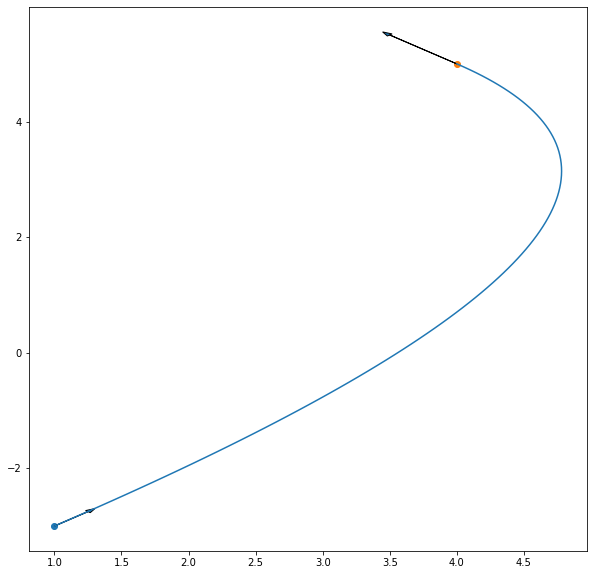

In [32]:
P1=(1,-3)
P2=(4,5)
u1=(0.25,0.25)
u2=(-0.5,0.5)
plt.scatter(P1[0],P1[1],marker='o')
plt.scatter(P2[0],P2[1],marker='o')
plt.arrow(P1[0],P1[1],u1[0],u1[1],head_width=0.05)
plt.arrow(P2[0],P2[1],u2[0],u2[1],head_width=0.05)
u,v=gamma(np.linspace(0,1,100),P1,P2,u1,u2)
plt.plot(u,v);



### Intégration

#### Tâche 7
Intégrer le mécanisme d'interpolation dans (une nouvelle version de) la fonction `level_curve` qui accepte un nouveau paramètre entier `oversampling` (sur-échantillonnage) tel que :

  - si `oversampling == 1`, la fonction `level_curve` fonctionne comme précédemment,

  - si `oversampling > 1`, la fonction `level_curve` introduit dans son résultat `oversampling - 1` points supplémentaires obtenus par interpolations entre chaque couple de points consécutifs obtenus par la méthode de Newton.

In [33]:
def level_curve3(f, x0, y0, oversampling,delta=0.1, N=100, eps=eps):
    if oversampling==1:
        return level_curve2(f, x0, y0, delta=0.1, N=100, eps=eps)
    else:
        grad_f=grad(f)
        c=f(x0,y0)
        def F(x,y):
            return np.array([f(x,y)-c,(0.999*x - x0)**2 + (0.99*y - y0)**2-delta**2])
        tableau=[[x0,y0]]
        a,b=next(f,x0,y0,delta=0.1)#pour nous permettre de fixer deja les 2 points de depart ici 
        x1,y1=Newton(F,a,b,eps,N=100)#a et b sont justes intermediaires pour trouver x1 et y1
        u11,u12=grad_f(x0,y0)#gradient au point(x0,y0)
        u21,u22=grad_f(x1,y1)#gradient au point(x1,y1)
        u1=(u12,-u11)#tangente a droite(sens de parcours) au pt(x0,y0) obtenue comme precedemment
        u2=(u22,-u21)#tangente a droite(sens de parcours) au pt(x1,y1)
        P1=(x0,y0)
        P2=(x1,y1) 
        A=gamma(np.linspace(0,1,oversampling-1),P1,P2,u1,u2) 
        for i in range(oversampling-1):                   
            tableau.append([A[0][i],A[1][i]])
        tableau.append([x1,y1])
        x0,y0=x1,y1
        b=0
        for i in range(N-1):#on est deja 'rentre' dans la boucle une fois pour trouver x1,y1
            d,e=next(f,x0,y0,delta=0.1)
            x0,y0=Newton(F,d,e,eps,N=100)
            tableau.append([x0,y0])
            b+=1#j'implemente un compteur pour bien verfier que l'on peut tracer avec moins de Npts
            if isin(tableau[0][0],tableau[0][1],x1,y1,tableau[-2][0],tableau[-2][1],x0,y0):
                print(f"le nombre de points nécessaire est {b}")
                x,y=tableau[-2][0],tableau[-2][1]
                u11,u12=grad_f(x,y)#gradient au point(x0,y0)
                u21,u22=grad_f(x0,y0)#gradient au point(x1,y1)
                u1=(u12,-u11)#tangente a droite(sens de parcours) au pt(x0,y0) obtenue comme precedemment
                u2=(u22,-u21)#tangente a droite(sens de parcours) au pt(x1,y1)
                P1=(x,y)
                P2=(x0,y0) 
                A=gamma(np.linspace(0,1,oversampling-1),P1,P2,u1,u2) 
                for i in range(oversampling-1):                   
                    tableau.append([A[0][i],A[1][i]])
                break
            t=tableau.pop()#on enleve le dernier pour avoir un tab bien ordonne
            x,y=tableau[-1][0],tableau[-1][1]
            u11,u12=grad_f(x,y)#gradient au point(x0,y0)
            u21,u22=grad_f(x0,y0)#gradient au point(x1,y1)
            u1=(u12,-u11)#tangente a droite(sens de parcours) au pt(x0,y0) obtenue comme precedemment
            u2=(u22,-u21)#tangente a droite(sens de parcours) au pt(x1,y1)
            P1=(x,y)
            P2=(x0,y0) 
            A=gamma(np.linspace(0,1,oversampling-1),P1,P2,u1,u2) 
            for i in range(oversampling-1):                   
                tableau.append([A[0][i],A[1][i]])
            tableau.append(t)
        print(f"Nous avons bien {len(tableau)} points")
        return np.transpose(tableau)



#### Tâche 8

Valider graphiquement le résultat au moyen des exemples de référence.

le nombre de points nécessaire est 34
Nous avons bien 211 points


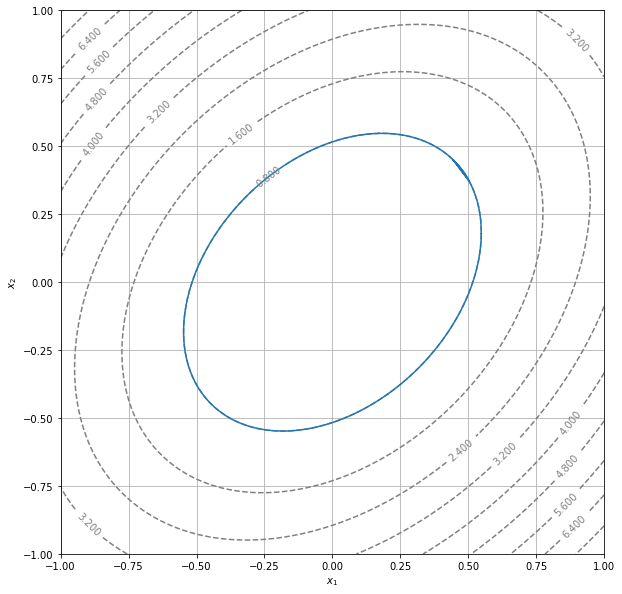

In [34]:
a,b=level_curve3(f1,0.4472135970019964, 0.4472135970019964,6)


display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)
plt.plot(a,b);

le nombre de points nécessaire est 30
Nous avons bien 311 points


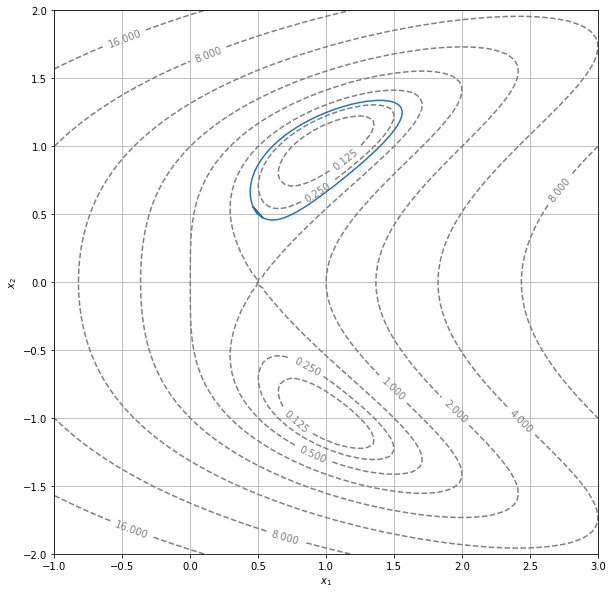

In [35]:
a,b=level_curve3(f2,0.5,0.5,10)
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)
plt.plot(a,b);

le nombre de points nécessaire est 55
Nous avons bien 225 points


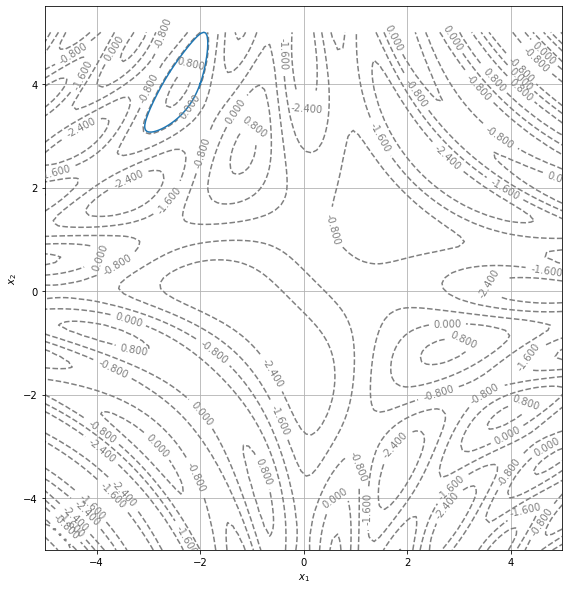

In [36]:
a,b=level_curve3(f3,-2.0,4.0 ,4)

display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)
plt.plot(a,b);